# Burgers backwards opt in phiflow-TF optim

Use actual TF optimizer

In [1]:
from phi.tf.flow import *

# run with phiflow
n = 128
dt = 1./32.
initial = np.zeros([n,1]) # start from 0

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state0 = BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)

# now use a real TF variable instead
state_in = state0.copied_with(velocity= variable(state0.velocity) ) # <-- main change!
states = [state_in]

for i in range(32):
    states.append( Burgers().step(states[-1],dt=dt) )

print("Each velocity is a phiflow grid like this one: " + format(states[-1].velocity) )
#print("\nFinal vel: " + format(state[-1].velocity.data[0][0:10]) )

Could not load resample cuda libraries: CUDA binaries not found at /Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them



Instructions for updating:
Use `tf.cast` instead.





/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


Each velocity is a phiflow grid like this one: Grid[128(1), size=[2.], <class 'numpy.float32'>]


Note, this didnt run anything! let's set up the loss

In [2]:
sess = Session(None) 

solution_t16 = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] )
target = state0.copied_with(velocity=np.reshape(solution_t16,[n,1]))

loss = math.sum( (states[16].velocity.data - target.velocity.data)**2 ) / n

Note: because we're only constraining timestep 16, we could actually omit steps 17 to 31 here, but for fairness and comparison with the PINN case, let's include them.

Now we don't need to keep track and pass along `state_in`, TF knows about the initial state as a variable we'd like to optimize.

In [3]:
LR = 5.

optim = tf.train.GradientDescentOptimizer(learning_rate=LR).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss) # overshoots?
sess.initialize_variables() # TODO dup

print('Initial loss: %f' % sess.run(loss))

import time
start = time.time()

for optim_step in range(50):
    _, loss_value = sess.run([optim, loss])
    
    if optim_step%5==0: 
        print('Step %d, loss: %f' % (optim_step,loss_value))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Initial loss: 0.382915
Step 0, loss: 0.382915
Step 5, loss: 0.194040
Step 10, loss: 0.103610
Step 15, loss: 0.059475
Step 20, loss: 0.035991
Step 25, loss: 0.022581
Step 30, loss: 0.014490
Step 35, loss: 0.009447
Step 40, loss: 0.006238
Step 45, loss: 0.004161
Runtime 1.89s


Let's visualize the reconstruction: first how well the last state of the simulation matches the target

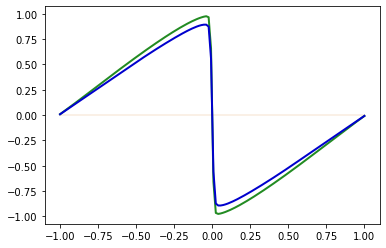

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# initial guess for optimization, this is where we started out...
fig.plot(pltx, initial.flatten()             , lw=2, color='linen')  

# target constraint at t=0.5
fig.plot(pltx, target.velocity.data.flatten(), lw=2, color='forestgreen') 

# constrained state of simulation
contrained_state = sess.run(states[16]).velocity.data
fig.plot(pltx, contrained_state.flatten(), lw=2, color='mediumblue')

Not bad. How well is the initial state recovered via backpropagation through the 16 simulation steps?
Also matches quite well:

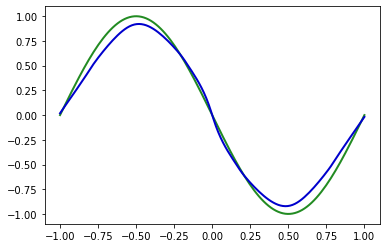

In [6]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# ground truth state at time=0 , move down
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )
fig.plot(pltx, t0gt.flatten()             , lw=2, color='forestgreen')  # ground truth initial state of sim

#fig.plot(pltx, stateN.velocity.data.flatten(), lw=2, color='mediumblue') # manual
fig.plot(pltx, sess.run(states[0]).velocity.data.flatten(), lw=2, color='mediumblue') # manual


And as image over time...

(1, 128, 33, 1)


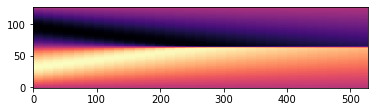

In [8]:
def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)

    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    plt.imshow(a, origin='lower', cmap='magma')
    
# run all states through TF to get numpy arrays 
vels = sess.run(states) # convert all states in 1 sess.run() call
vels = [ x.velocity.data for x in vels] 
#vels = np.asarray( [ sess.run(x, feed_dict={state_in: stateN}).velocity.data for x in states] ) # also works, but slower
sn = np.concatenate(vels, axis=-1)
sn = np.reshape(sn, list(sn.shape)+[1] ) ; print(sn.shape)

show_state(sn)

So far only 1D Burgers, but this works with more complex model equations and higher dimensions in just the same way.